In [54]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from IPython import display


import fnmatch

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [55]:
data_dir = pathlib.Path(r"D:\magistracy\diplom\records_cut")
filenames = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if(file.endswith(".wav")):
            filenames.append(os.path.join(root,file))

In [56]:
notes = np.array(['A','G#','G','F#','F','E','D#','D','C#','C','B','A#'])
print('Notes:', notes)

Notes: ['A' 'G#' 'G' 'F#' 'F' 'E' 'D#' 'D' 'C#' 'C' 'B' 'A#']


In [57]:
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/notes[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 30828
Number of examples per label: 2318
Example file tensor: tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\D#\\en027a_55.wav', shape=(), dtype=string)


In [58]:
filenames = filenames[:28000]

train_files = filenames[:19600]
val_files = filenames[19600: 19600 + 5600]
test_files = filenames[-2800:]

print('Размер обучающего набора', len(train_files))
print('Размер проверочного набора', len(val_files))
print('Размер тестового набора', len(test_files))

Размер обучающего набора 19600
Размер проверочного набора 5600
Размер тестового набора 2800


In [59]:
# После разделения изначальных аудио-файлов на ноты все получившиеся записи стали моно-записями
test_file = tf.io.read_file(filenames[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([11506, 1])

In [60]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary) # возвращает WAV-кодированные как Тензор и частотой дискретизации.
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # Примечание. Здесь будет использоваться индексирование вместо распаковки кортежей, 
    # чтобы это работало на графике TensorFlow.
    return parts[-2]

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def without_zero_len(waveform, label):
    if len(waveform)!=0:  
        return True
    return False

In [61]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
count = 0
for a,_ in waveform_ds:
    count+=1
    if a.shape[0]==0:
        print(count, filenames[count])
waveform_ds = waveform_ds.filter(without_zero_len) # Удаляем сигналы нулевой длины

1171 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\G\\en045a_5.wav', shape=(), dtype=string)
2199 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\G\\en022b_76.wav', shape=(), dtype=string)
4355 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F#\\en049a_84.wav', shape=(), dtype=string)
4425 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\E\\kr021b_42.wav', shape=(), dtype=string)
8201 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F#\\kr002b_204.wav', shape=(), dtype=string)
9690 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\D#\\kr038b_134.wav', shape=(), dtype=string)
12707 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\D\\kr019a_8.wav', shape=(), dtype=string)
14965 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F#\\en012b_80.wav', shape=(), dtype=string)
17485 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\C#\\kr005b_65.wav', shape=(), dtype=string)
19349 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\G\\en031a_54.wav', shape=(), dtype=string)


In [62]:
# Загружаем триангулярные фильтры
with open('filters.npy', 'rb') as f:
    fbank = np.load(f)
    
fbank = tf.convert_to_tensor(fbank.T, dtype=tf.float32)   
print(fbank.shape)

(1025, 40)


In [63]:
def get_spectrogram(params):
    waveform = params[0]
    S = tf.convert_to_tensor(params[1])
    NFFT = 2048
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.stft(waveform, frame_length=NFFT, frame_step=S,pad_end=True)
    spectrogram = tf.abs(spectrogram)
    pow_frames = ((1.0 / NFFT) * ((spectrogram) ** 2))
    filter_banks = tf.tensordot(pow_frames, fbank, axes = [[1], [0]])
    filter_banks = tf.where(filter_banks == 0, tf.keras.backend.epsilon(), filter_banks)  # Численная стабильность 
    # tf.keras.backend.epsilon() - машинный ноль)
    spectrogram = tf.math.log(filter_banks)  # Логарифмические энергии набора фильтров

    return spectrogram

In [64]:
def get_spectrogram_and_label_id(audio, label, step):
    spectrogram = get_spectrogram((audio,step))
    #spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == notes)
    return spectrogram, label_id

def get_spectrogram_and_label_id_lim(spectrogram, label_id, M):
    spec_length = len(spectrogram)
    if spec_length<M:
        for k in range(M-spec_length):
            spect_last = spectrogram[spec_length-1]
            spect_last = tf.expand_dims(spect_last, 0)
            spectrogram = tf.concat([spectrogram, spect_last], 0)
    elif spec_length>M:
        start = tf.random.uniform(shape=[], minval=0, maxval=spec_length-M, dtype=tf.int32)
        spectrogram = spectrogram[start:start+M]
    else:
        spectrogram = spectrogram
    return spectrogram, label_id

In [65]:
step = list(map(int,[2048/32, 2048/16, 2048/8, 2048/4, 2048/2, 2048]))
num_frame = [5,10,15,20,25,30]
params_s_f = [] 

for s in step:
    for f in num_frame:
        params_s_f.append((s,f))
print('Количество вариантов step', len(step))
print('Количество вариантов num_frame', len(num_frame))
print('Количество баз данных', len(params_s_f))

Количество вариантов step 6
Количество вариантов num_frame 6
Количество баз данных 36


In [66]:
params_s_f

[(64, 5),
 (64, 10),
 (64, 15),
 (64, 20),
 (64, 25),
 (64, 30),
 (128, 5),
 (128, 10),
 (128, 15),
 (128, 20),
 (128, 25),
 (128, 30),
 (256, 5),
 (256, 10),
 (256, 15),
 (256, 20),
 (256, 25),
 (256, 30),
 (512, 5),
 (512, 10),
 (512, 15),
 (512, 20),
 (512, 25),
 (512, 30),
 (1024, 5),
 (1024, 10),
 (1024, 15),
 (1024, 20),
 (1024, 25),
 (1024, 30),
 (2048, 5),
 (2048, 10),
 (2048, 15),
 (2048, 20),
 (2048, 25),
 (2048, 30)]

In [67]:
def preprocess_dataset(files,s,f):
    files_ds = tf.data.Dataset.from_tensor_slices(train_files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.filter(without_zero_len) 
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,s), num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id_lim(x,y,f))
    return output_ds

In [68]:
def create_model(input_shape):
    inputs = layers.Input(shape = input_shape, name = "inputs")
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation = 'relu', name = "relu_1")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_2")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_3")(x)
    outputs = layers.Dense(12,activation = 'softmax', name = "dense_end")(x)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [69]:
import time
EPOCHS = 100
models = []
histories = []

In [70]:
start_time0 = time.time()
tests_acc = []
for k in range(len(params_s_f)):
    print('---------------------------------------------------------------------')
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
    train_ds = []
    val_ds = []
    test_ds = []
    spectrogram_ds = waveform_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,params_s_f[k][0]), num_parallel_calls=AUTOTUNE)
    spectrogram_ds = spectrogram_ds.map(lambda x, y: get_spectrogram_and_label_id_lim(x,y,params_s_f[k][1]))
    train_ds = spectrogram_ds
    val_ds = preprocess_dataset(val_files,params_s_f[k][0],params_s_f[k][1])
    test_ds = preprocess_dataset(test_files,params_s_f[k][0],params_s_f[k][1])
    
    batch_size = 64
    train_ds = train_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    
    test_audio = []
    test_labels = []

    for audio, label in test_ds:
        test_audio.append(audio.numpy())
        test_labels.append(label.numpy())

    test_audio = np.array(test_audio)
    test_labels = np.array(test_labels)

    for spectrogram, _ in spectrogram_ds.take(1):
        input_shape = spectrogram.shape
        print('input_shape',input_shape)
    
    
    mymodel = create_model(input_shape)
    
    start_time = time.time()
    myhistory = mymodel.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=0)
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    
    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
    y_true = test_labels
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc.append(test_acc)
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')
    models.append(mymodel)
    histories.append(myhistory)
    
    
minutes, seconds = ((time.time() - start_time0) - 3600 * ((time.time() - start_time0) // 3600)) // 60, (time.time() - start_time0) % 60    
print(f"--- {minutes} минут {seconds} секунд ---")

---------------------------------------------------------------------
Шаг: 64 , количество спектрограмм:  5
input_shape (5, 40)
--- 9.0 минут 17.897860050201416 секунд ---
Шаг: 64 , количество спектрограмм:  5 , accuracy тестовой выборки:  74.61459928534967 %
---------------------------------------------------------------------
Шаг: 64 , количество спектрограмм:  10
input_shape (10, 40)
--- 10.0 минут 4.040066242218018 секунд ---
Шаг: 64 , количество спектрограмм:  10 , accuracy тестовой выборки:  74.70137825421133 %
---------------------------------------------------------------------
Шаг: 64 , количество спектрограмм:  15
input_shape (15, 40)
--- 9.0 минут 53.128788232803345 секунд ---
Шаг: 64 , количество спектрограмм:  15 , accuracy тестовой выборки:  76.01837672281776 %
---------------------------------------------------------------------
Шаг: 64 , количество спектрограмм:  20
input_shape (20, 40)
--- 8.0 минут 51.09630799293518 секунд ---
Шаг: 64 , количество спектрограмм:  20 , 

input_shape (10, 40)
--- 7.0 минут 1.3682119846343994 секунд ---
Шаг: 2048 , количество спектрограмм:  10 , accuracy тестовой выборки:  93.82848392036753 %
---------------------------------------------------------------------
Шаг: 2048 , количество спектрограмм:  15
input_shape (15, 40)
--- 8.0 минут 29.954687118530273 секунд ---
Шаг: 2048 , количество спектрограмм:  15 , accuracy тестовой выборки:  94.52271567126085 %
---------------------------------------------------------------------
Шаг: 2048 , количество спектрограмм:  20
input_shape (20, 40)
--- 9.0 минут 9.035885095596313 секунд ---
Шаг: 2048 , количество спектрограмм:  20 , accuracy тестовой выборки:  93.17508933129147 %
---------------------------------------------------------------------
Шаг: 2048 , количество спектрограмм:  25
input_shape (25, 40)
--- 8.0 минут 35.72247552871704 секунд ---
Шаг: 2048 , количество спектрограмм:  25 , accuracy тестовой выборки:  87.93772332822869 %
---------------------------------------------

In [71]:
for k in range(len(models)):
    print(k, params_s_f[k][0])
    models[k].summary()

0 64
Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 5, 40)]           0         
                                                                 
 flatten_40 (Flatten)        (None, 200)               0         
                                                                 
 relu_1 (Dense)              (None, 512)               102912    
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 634,380
Trainable params: 634,380
Non-t

                                                                 
Total params: 634,380
Trainable params: 634,380
Non-trainable params: 0
_________________________________________________________________
7 128
Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 10, 40)]          0         
                                                                 
 flatten_47 (Flatten)        (None, 400)               0         
                                                                 
 relu_1 (Dense)              (None, 512)               205312    
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                              

 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 736,780
Trainable params: 736,780
Non-trainable params: 0
_________________________________________________________________
14 256
Model: "model_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 15, 40)]          0         
                                                                 
 flatten_54 (Flatten)        (None, 600)               0         
                                                                 
 relu_1 (Dense)              (None, 512)     

                                                                 
 flatten_60 (Flatten)        (None, 600)               0         
                                                                 
 relu_1 (Dense)              (None, 512)               307712    
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 839,180
Trainable params: 839,180
Non-trainable params: 0
_________________________________________________________________
21 512
Model: "model_61"
_________________________________________________________________
 Layer (type)                Output Shape    

27 1024
Model: "model_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 20, 40)]          0         
                                                                 
 flatten_67 (Flatten)        (None, 800)               0         
                                                                 
 relu_1 (Dense)              (None, 512)               410112    
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 941,580
Trainable params: 941,580
No

 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 941,580
Trainable params: 941,580
Non-trainable params: 0
_________________________________________________________________
34 2048
Model: "model_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 25, 40)]          0         
                                                                 
 flatten_74 (Flatten)        (None, 1000)              0         
                                                                 
 relu_1 (Dense)              (None, 512)               512512    
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)    

In [72]:
np.array(tests_acc)

array([74.61459929, 74.70137825, 76.01837672, 77.27411945, 76.61562021,
       80.67891782, 75.65084227, 76.71260847, 80.62787136, 80.5870342 ,
       84.30321593, 81.29657989, 72.95048494, 83.3639612 , 84.81878509,
       89.95916284, 89.5712098 , 89.32108218, 82.53700868, 88.79530373,
       90.34201123, 93.71618173, 95.16079632, 93.86421644, 86.86574783,
       94.58907606, 94.21643696, 93.96630934, 94.1194487 , 90.62276672,
       94.86983155, 93.82848392, 94.52271567, 93.17508933, 87.93772333,
       92.63399694])

Text(51.0, 0.5, 'Шаг')

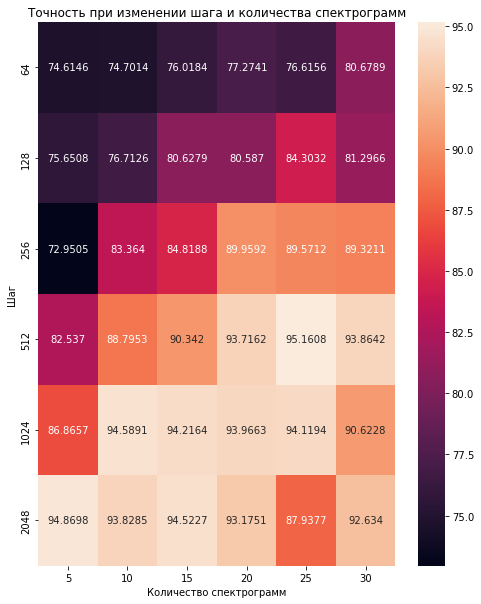

In [73]:
test_acc_mtx = np.zeros((len(step),len(num_frame)))
p = 0
for s in range(len(step)):
    for f in range(len(num_frame)):
        test_acc_mtx[s][f] = tests_acc[p]
        p+=1
plt.figure(figsize=(8, 10))
sns.heatmap(test_acc_mtx, xticklabels=num_frame, yticklabels=step, 
            annot=True, fmt='g')
plt.title('Точность при изменении шага и количества спектрограмм')
plt.xlabel('Количество спектрограмм')
plt.ylabel('Шаг')

Лучшая точность $(95.1608 \%)$ соответствует $25$ спектрограммам и шагу $512$.

In [74]:
for k in range(len(params_s_f)):
    print(k, params_s_f[k],tests_acc[k])

0 (64, 5) 74.61459928534967
1 (64, 10) 74.70137825421133
2 (64, 15) 76.01837672281776
3 (64, 20) 77.27411944869831
4 (64, 25) 76.6156202143951
5 (64, 30) 80.67891781521185
6 (128, 5) 75.65084226646248
7 (128, 10) 76.71260847371107
8 (128, 15) 80.62787136294027
9 (128, 20) 80.58703420112302
10 (128, 25) 84.30321592649311
11 (128, 30) 81.2965798876978
12 (256, 5) 72.95048494129658
13 (256, 10) 83.36396120469627
14 (256, 15) 84.81878509443594
15 (256, 20) 89.95916283818275
16 (256, 25) 89.57120980091884
17 (256, 30) 89.32108218478815
18 (512, 5) 82.53700867789688
19 (512, 10) 88.79530372639101
20 (512, 15) 90.3420112302195
21 (512, 20) 93.71618172537009
22 (512, 25) 95.16079632465544
23 (512, 30) 93.86421643695762
24 (1024, 5) 86.86574783052578
25 (1024, 10) 94.58907605921388
26 (1024, 15) 94.21643695763144
27 (1024, 20) 93.96630934150076
28 (1024, 25) 94.11944869831547
29 (1024, 30) 90.62276671771312
30 (2048, 5) 94.8698315467075
31 (2048, 10) 93.82848392036753
32 (2048, 15) 94.522715671

In [75]:
k_max = np.argmax(np.array(tests_acc))
k_max

22

In [76]:
params_s_f[k_max][0],params_s_f[k_max][1]

(512, 25)

In [77]:
train_ds = []
val_ds = []
test_ds = []

spectrogram_ds = waveform_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,params_s_f[k_max][0]), num_parallel_calls=AUTOTUNE)
spectrogram_ds = spectrogram_ds.map(lambda x, y: get_spectrogram_and_label_id_lim(x,y,params_s_f[k_max][1]))
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files,params_s_f[k_max][0],params_s_f[k_max][1])
test_ds = preprocess_dataset(test_ds,params_s_f[k_max][0],params_s_f[k_max][1])

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [78]:
test_audio = []
test_labels = []
for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [79]:
history_ = histories[k_max]
model_ = models[k_max]
metrics = history_.history

y_pred = np.argmax(model_.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100
test_acc

95.16079632465544

[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная')]

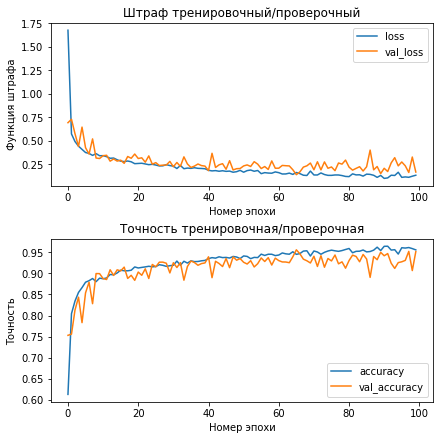

In [80]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(history_.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный')

axes[1].plot(history_.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная')

График val_loss постепенно идет к низу, поэтому переобучения нет.

In [81]:
y_pred = np.argmax(model_.predict(test_audio), axis=1)
y_true = test_labels

In [82]:
y_true.shape

(19590,)

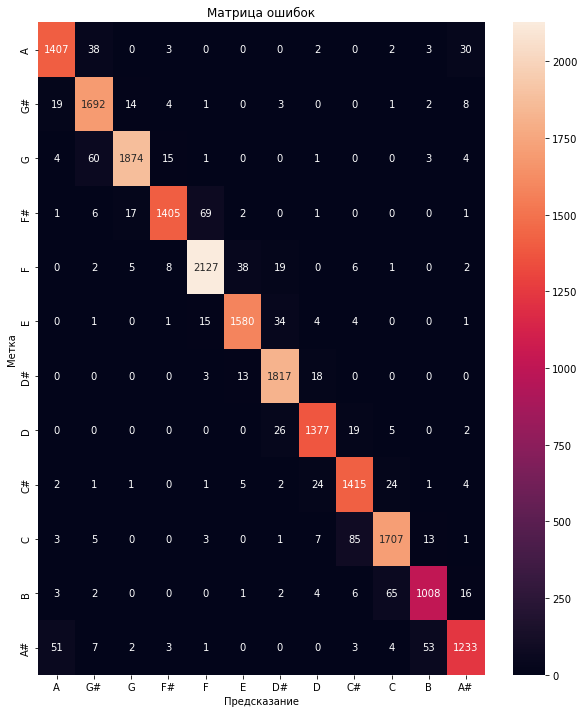

In [83]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 12))
sns.heatmap(confusion_mtx, xticklabels=notes, yticklabels=notes, 
            annot=True, fmt='g')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.title('Матрица ошибок')
plt.show()

In [84]:
sample_file = data_dir/'E/arpeg-CMaj-060BPM-leg_2.wav'
print('Sample file:', sample_file)
files_ds = tf.data.Dataset.from_tensor_slices([str(sample_file)])
output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
output_ds = output_ds.filter(without_zero_len) 
output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,params_s_f[k_max][0]), num_parallel_calls=AUTOTUNE)
sample_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id_lim(x,y,params_s_f[k_max][1]))

Sample file: D:\magistracy\diplom\records_cut\E\arpeg-CMaj-060BPM-leg_2.wav


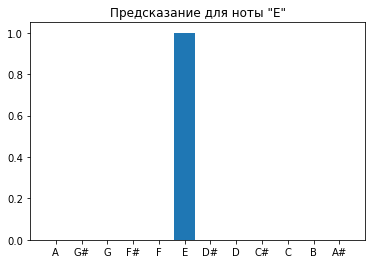

In [85]:
for spectrogram, label in sample_ds.batch(1):
    prediction = model_(spectrogram)
    plt.bar(notes, prediction[0])
    t = 'Предсказание для ноты "'+ notes[label[0]]+'"'
    plt.title(t)
    plt.show()


In [87]:
# Сохраняем модель
model_.save(r"D:\magistracy\diplom\model\model_3.h5")